# 3.4 Author Level Topic Modeling LCC
Builds author level topic models using LDA, restricted to the Largest Weakly Connected Component (LCC) when available, for clean alignment with author graphs and clustering.

In [ ]:
import os
from pathlib import Path

# --- ENVIRONMENT SWITCH ---
# Set to True if running on local machine with Google Drive Desktop mounted
# Set to False if running in Google Colab cloud
RUNNING_LOCALLY = True

if RUNNING_LOCALLY:
    # Standard macOS path for Google Drive Desktop
    BASE_PATH = Path('/Volumes/GoogleDrive/MyDrive/AI Public Trust')
else:
    # Google Colab cloud path
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/drive/MyDrive/AI Public Trust')

# Pre-compute critical paths used across notebooks
twits_folder = BASE_PATH / 'Raw Data/Twits/'
test_folder = BASE_PATH / 'Raw Data/'
datasets_folder = BASE_PATH / 'Data Sets'
cleanedds_folder = BASE_PATH / 'Data Sets/Cleaned Data'
networks_folder = BASE_PATH / 'Data Sets/Networks/'
literature_folder = BASE_PATH / 'Literature/'
topic_models_folder = BASE_PATH / 'Models/Topic Modeling/'


## 0. Environment and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, re, json, math, gc, sys, glob, itertools, csv, gzip, pickle
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import psutil
import itertools
import time
import shutil

import re, json, os
from collections import defaultdict, Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


import os
if not RUNNING_LOCALLY:
    print('Running Colab setup shell commands...')
    os.system('pip install spacy')
else:
    print('Running locally: Skipping Colab shell setup.')

!python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


import networkx as nx


import os
if not RUNNING_LOCALLY:
    print('Running Colab setup shell commands...')
    os.system('pip install gensim')
else:
    print('Running locally: Skipping Colab shell setup.')

try:
    import gensim
    from gensim.models.coherencemodel import CoherenceModel
    from gensim.corpora import Dictionary as GensimDictionary
    GENSIM_OK = True
except Exception:
    GENSIM_OK = False


try:
    import pyLDAvis
    import pyLDAvis.sklearn
    PYLDAVIS_OK = True
except Exception:
    PYLDAVIS_OK = False

print("GENSIM_OK =", GENSIM_OK, " PYLDAVIS_OK =", PYLDAVIS_OK)


import matplotlib.pyplot as plt
import seaborn as sns

import os
if not RUNNING_LOCALLY:
    print('Running Colab setup shell commands...')
    os.system('pip install umap-learn')
else:
    print('Running locally: Skipping Colab shell setup.')

import umap

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

nltk_stopwords = stopwords.words("english")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
GENSIM_OK = True  PYLDAVIS_OK = False


In [2]:
MAX_TWEETS = 1_000_000   # adjust this number to run on full set



## 1. Paths

In [3]:
BASE = Path('/content/drive/My Drive/Colab Projects/AI Public Trust')
DATA_DIR = BASE / 'Data Sets' / 'Cleaned Data'
NETWORKS_DIR = BASE / 'Data Sets' / 'Networks'
LEIDEN_DIR = NETWORKS_DIR / 'leiden_runs'

TWEETS_PATH = DATA_DIR / 'AItrust_pruned_twits_with_sentiment.json'
LCC_GML = NETWORKS_DIR / 'Largest_Weakly_Connected_Component.gml'

OUT_DIR = BASE / 'Models' / 'Topic Modeling' / 'LDA' / 'author_level'
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR :", DATA_DIR)
print("NETWORKS :", NETWORKS_DIR)
print("TWEETS   :", TWEETS_PATH)
print("LCC_GML  :", LCC_GML)
print("OUT_DIR  :", OUT_DIR)

# ----------------------------------------------------
# Copy large tweet file from Drive to local /content/
# and use the local path for streaming
# ----------------------------------------------------

LOCAL_TWEETS_PATH = Path("/content/AItrust_pruned_twits_with_sentiment.json")
if not LOCAL_TWEETS_PATH.exists():
    print("Copying tweets file to local disk...")
    shutil.copy(TWEETS_PATH, LOCAL_TWEETS_PATH)
else:
    print("Local tweets file already exists.")

TWEETS_PATH = LOCAL_TWEETS_PATH
print("Using tweets from:", TWEETS_PATH)


DATA_DIR : /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Cleaned Data
NETWORKS : /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Networks
TWEETS   : /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Cleaned Data/AItrust_pruned_twits_with_sentiment.json
LCC_GML  : /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Networks/Largest_Weakly_Connected_Component.gml
OUT_DIR  : /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level
Local tweets file already exists.
Using tweets from: /content/AItrust_pruned_twits_with_sentiment.json


## 2. Utilities

In [4]:


def read_json_lines(path):
    """Stream a JSON object per line, no accumulation, no fallback."""
    path = str(path)
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f, start=1):
            s = line.strip()
            if not s:
                continue
            try:
                yield json.loads(s)
            except Exception as e:
                print(f"Skipping malformed line {i}: {e}")
                continue


def load_lcc_node_ids(gml_path):
    try:
        g = nx.read_gml(gml_path)
        nodes = list(g.nodes())
        return set(str(n) for n in nodes)
    except Exception as e:
        print("Warning: could not load LCC GML:", e)
        return None

def normalize_ws(s):
    return re.sub(r"\s+", " ", s or "").strip()

def tokenize_minimal(s):
    s = s or ""
    s = s.lower()
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"[^a-z0-9_\s]", " ", s)
    return normalize_ws(s)



def lemmatize_text(doc):
    """
    Lemmatize a text string using spaCy.
    Keeps only alphabetic tokens, removes stopwords,
    and returns a space-separated string.
    """
    doc_spacy = nlp(doc)
    lemmas = []
    for token in doc_spacy:
        if token.is_alpha:
            lemmas.append(token.lemma_.lower().strip())
    return " ".join(lemmas)


## 3. Load tweets and restrict to LCC authors

In [6]:
#!head -n 5 "/content/drive/MyDrive/AI Public Trust/Data Sets/Cleaned Data/AItrust_pruned_twits_with_sentiment.json"


In [33]:
#os.path.getsize(LCC_GML)


In [5]:
def load_lcc_node_ids_lightweight(gml_path):
    nodes = set()
    with open(gml_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith("id "):
                node_id = line[3:].strip().strip('"')
                nodes.add(node_id)
    return nodes

lcc_nodes = load_lcc_node_ids_lightweight(LCC_GML)
print("Loaded LCC node count:", len(lcc_nodes))


Loaded LCC node count: 3264499


In [6]:

author_texts = defaultdict(list)
author_stats = Counter()

n_total = 0
n_kept = 0
n_missing_text = 0

LOG_EVERY = 10000       # print every N tweets

print(f"\nStreaming tweets from: {TWEETS_PATH}")
t0 = time.time()

try:
    for i, tw in enumerate(itertools.islice(read_json_lines(TWEETS_PATH), MAX_TWEETS), start=1):
        n_total += 1
        aid = str(tw.get("author_id", "")).strip()
        if not aid:
            continue
        if lcc_nodes is not None and aid not in lcc_nodes:
            continue

        txt = tw.get("processed_text") or tokenize_minimal(tw.get("text", ""))
        if not txt:
            n_missing_text += 1
            continue

        author_texts[aid].append(txt)
        author_stats[aid] += 1
        n_kept += 1

        # --- Regular progress prints ---
        if i % LOG_EVERY == 0:
            mem = psutil.virtual_memory()
            used = mem.used / (1024**3)
            free = mem.available / (1024**3)
            elapsed = (time.time() - t0) / 60
            print(f"[{i:,} tweets] {len(author_texts):,} authors "
                  f"| {n_kept:,} kept "
                  f"| {used:.1f} GB used, {free:.1f} GB free "
                  f"| {elapsed:.1f} min elapsed")

except Exception as e:
    print(f"\nError while streaming tweets: {e}")

print("\n--- Summary ---")
print(f"Total tweets read: {n_total:,}")
print(f"Kept after LCC filter: {n_kept:,}")
print(f"Authors retained: {len(author_texts):,}")
print(f"Tweets missing text: {n_missing_text:,}")
print(f"Elapsed time: {(time.time() - t0)/60:.1f} minutes")

# --- Build author documents and export overview ---
author_docs = {}
for aid, parts in author_texts.items():
    joined = " ".join(parts)
    cleaned = normalize_ws(joined)
    lemma = lemmatize_text(cleaned)
    author_docs[aid] = lemma

rows = []
for aid, parts in author_texts.items():
    rows.append({
        "author_id": aid,
        "n_tweets": int(author_stats[aid]),
        "avg_len_tokens_est": int(np.mean([len(p.split()) for p in parts])) if parts else 0
    })

df_auth = pd.DataFrame(rows).sort_values("n_tweets", ascending=False)
out_path = OUT_DIR / "author_docs.csv"
df_auth.to_csv(out_path, index=False, encoding="utf-8")

print(f"\nSaved author_docs.csv to: {out_path}")



Streaming tweets from: /content/AItrust_pruned_twits_with_sentiment.json
[570,000 tweets] 1,136 authors | 2,663 kept | 2.6 GB used, 9.7 GB free | 1.6 min elapsed

--- Summary ---
Total tweets read: 1,000,000
Kept after LCC filter: 4,558
Authors retained: 1,704
Tweets missing text: 0
Elapsed time: 2.5 minutes

Saved author_docs.csv to: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/author_docs.csv


## 4. Vectorize author documents

In [7]:
# ----- Custom domain-specific stopwords for the LDA specifically -----
custom_stopwords = {
    'user', 'rt', 'chatgpt', 'gpt', 'gpt4', 'gpt3', 'ai', 'llm',
    'http', 'https', 'amp', 'new', 'like', 'just', 'use', 'using',
    'don', 'did', 'does', 'people', 'today', 'code', 'asked',
    'know', 'good', 'time', 'think', 'make', 'work'
}


In [8]:
# Which representations to try (for now we keep it simple, expand later)
REPRESENTATIONS = [
     {"name": "bow_unigram", "use_tfidf": False, "use_bigrams": False},
     {"name": "bow_unigram_bigram", "use_tfidf": False, "use_bigrams": True},
     {"name": "tfidf_unigram", "use_tfidf": True, "use_bigrams": False},
     {"name": "tfidf_unigram_bigram", "use_tfidf": True, "use_bigrams": True},
]


In [23]:
stopwords_extended = set(nltk_stopwords)
your_custom_stopwords = {
    "rt", "amp", "https", "co", "ai", "artificial", "intelligence"
}

stopwords_extended.update(your_custom_stopwords)
stopwords_extended = sorted(list(stopwords_extended))


In [25]:
author_ids = list(author_docs.keys())
corpus = [author_docs[aid] for aid in author_ids]

print("Number of authors:", len(author_ids))

representations = {
    "bow_unigram": CountVectorizer(
        lowercase=True,
        stop_words=stopwords_extended,
        max_df=0.95,
        min_df=5,
        ngram_range=(1,1)
    ),
    "bow_bigram": CountVectorizer(
        lowercase=True,
        stop_words=stopwords_extended,
        max_df=0.95,
        min_df=5,
        ngram_range=(1,2)
    ),
    "tfidf_unigram": TfidfVectorizer(
        lowercase=True,
        stop_words=stopwords_extended,
        max_df=0.95,
        min_df=5,
        ngram_range=(1,1),
        use_idf=True
    ),
    "tfidf_bigram": TfidfVectorizer(
        lowercase=True,
        stop_words=stopwords_extended,
        max_df=0.95,
        min_df=5,
        ngram_range=(1,2),
        use_idf=True
    )
}

results = {}

for name, vec in representations.items():
    print("\nUsing representation:", name)

    # Initial vectorization
    X = vec.fit_transform(corpus)
    vocab = vec.get_feature_names_out().tolist()

    # --------------------------------------------------
    # STRICT bigram stopword filtering
    # --------------------------------------------------
    if "bigram" in name:
        cleaned_vocab = []
        for w in vocab:
            parts = w.split()
            if len(parts) == 1:          # unigram (rare in bigram model)
                cleaned_vocab.append(w)
            elif all(p not in stopwords_extended for p in parts):
                cleaned_vocab.append(w)

        if len(cleaned_vocab) != len(vocab):
            print(f"Filtered bigram vocab from {len(vocab)} -> {len(cleaned_vocab)}")

            restricted_vectorizer = (
                CountVectorizer(vocabulary=cleaned_vocab)
                if "bow" in name
                else TfidfVectorizer(vocabulary=cleaned_vocab, use_idf=("tfidf" in name))
            )

            X = restricted_vectorizer.fit_transform(corpus)
            vocab = restricted_vectorizer.get_feature_names_out().tolist()

            vec = restricted_vectorizer   # update vectorizer

    print("Vocab size:", len(vocab), "X shape:", X.shape)

    results[name] = {
        "X": X,
        "vectorizer": vec,
        "vocab": vocab
    }

REPRESENTATION_TO_USE = "bow_bigram"


Number of authors: 1704

Using representation: bow_unigram
Vocab size: 1663 X shape: (1704, 1663)

Using representation: bow_bigram
Vocab size: 2469 X shape: (1704, 2469)

Using representation: tfidf_unigram
Vocab size: 1663 X shape: (1704, 1663)

Using representation: tfidf_bigram
Vocab size: 2469 X shape: (1704, 2469)


## 5. Fit LDA for K in grid and export

In [ ]:
K_GRID = [5, 8, 12, 20]
N_TOP_WORDS = 20

master_rows = []

for rep_name, rep_data in results.items():
    print("\n====================================================")
    print("Running LDA for representation:", rep_name)
    print("====================================================")

    X = rep_data["X"]
    vectorizer = rep_data["vectorizer"]
    vocab = rep_data["vocab"]

    # representation-specific output folder
    rep_out = OUT_DIR / rep_name
    rep_out.mkdir(parents=True, exist_ok=True)

    # prepare tokens for coherence
    if GENSIM_OK:
        tokens_by_doc = [doc.split() for doc in corpus]
    else:
        tokens_by_doc = None

    for K in K_GRID:
        print(f"\nFitting LDA: representation={rep_name}  K={K}")

        lda = LatentDirichletAllocation(
            n_components=K,
            learning_method='batch',
            max_iter=20,
            random_state=42,
            evaluate_every=5,
            verbose=1
        )
        lda.fit(X)


        # ---- Save author-topic matrix ----
        theta = lda.transform(X)
        df_theta = pd.DataFrame(theta)
        df_theta.insert(0, "author_id", author_ids)

        out_theta = rep_out / f"author_topic_matrix_k{K}.csv"
        df_theta.to_csv(out_theta, index=False)
        print("Saved matrix:", out_theta)

        # ---- Save top terms ----
        rows = []
        for topic_idx, comp in enumerate(lda.components_):
            top_idx = np.argsort(comp)[::-1][:N_TOP_WORDS]
            terms = [vocab[i] for i in top_idx]
            weights = [float(comp[i]) for i in top_idx]

            for t, w in zip(terms, weights):
                rows.append({"topic": topic_idx, "term": t, "weight": w})

        df_top = pd.DataFrame(rows)
        out_top = rep_out / f"author_topics_k{K}_top_terms.csv"
        df_top.to_csv(out_top, index=False)
        print("Saved top terms:", out_top)

        # ---- Coherence ----
        if GENSIM_OK:
            topic_lists = []
            for topic_idx, comp in enumerate(lda.components_):
                top_idx = np.argsort(comp)[::-1][:N_TOP_WORDS]
                topic_lists.append([vocab[i] for i in top_idx])

            try:
                dictionary = GensimDictionary(tokens_by_doc)
                cm = CoherenceModel(
                    topics=topic_lists,
                    texts=tokens_by_doc,
                    dictionary=dictionary,
                    coherence="c_v"
                )
                coh = float(cm.get_coherence())
            except Exception as e:
                print("Coherence failed:", e)
                coh = None
        else:
            coh = None

        # ---- Perplexity-like scoring ----
        try:
            perp = float(np.exp(-lda.score(X) / X.sum()))
        except:
            perp = None

        master_rows.append({
            "representation": rep_name,
            "K": K,
            "perplexity_like": perp,
            "coherence_c_v": coh
        })

        # ---- pyLDAvis ----
        if PYLDAVIS_OK:
            try:
                vis = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds="tsne")
                html_path = rep_out / f"author_lda_k{K}_pyLDAvis.html"
                pyLDAvis.save_html(vis, str(html_path))
                print("Saved pyLDAvis:", html_path)
            except Exception as e:
                print("pyLDAvis error:", e)

# ---- Save master summary ----
df_master = pd.DataFrame(master_rows)
master_path = OUT_DIR / "ALL_REPRESENTATIONS_LDA_SUMMARY.csv"
df_master.to_csv(master_path, index=False)
print("\nSaved master summary:", master_path)
print(df_master)



Running LDA for representation: bow_unigram

Fitting LDA: representation=bow_unigram  K=5
iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20, perplexity: 1246.6586
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20, perplexity: 1204.9318
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20, perplexity: 1190.3504
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20, perplexity: 1184.0964
Saved matrix: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/bow_unigram/author_topic_matrix_k5.csv
Saved top terms: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/

In [ ]:
def show_topics(rep, K, top_n=10):
    path = OUT_DIR / rep / f"author_topics_k{K}_top_terms.csv"
    print(f"\n=== Representation: {rep} | K={K} ===")
    df = pd.read_csv(path)
    for topic in sorted(df["topic"].unique()):
        terms = df[df["topic"] == topic].head(top_n)["term"].tolist()
        print(f"Topic {topic}: {', '.join(terms)}")

# Inspect best models
show_topics("tfidf_bigram", 5, top_n=10)
show_topics("tfidf_unigram", 20, top_n=10)

# Also useful baselines:
show_topics("bow_bigram", 8, top_n=10)
show_topics("bow_unigram", 5, top_n=10)



=== Representation: tfidf_bigram | K=5 ===
Topic 0: language, human, art, model, intelligence, generative, artificial, artificial intelligence, models, large
Topic 1: way search, way, search, bing edge, edge, search starts, starts, edge way, llms, ve
Topic 2: job, midjourney, write, news, vs, notion, wow, year, demo, nfts
Topic 3: great, agi, machine, intelligence, web, say, simple, chat, data, free
Topic 4: google, bard, search, bing, microsoft, powered, chatbot, google bard, engine, going

=== Representation: tfidf_unigram | K=20 ===
Topic 0: bard, google, models, language, announces, lamda, conversational, experimental, service, large
Topic 1: voice, generating, replaced, rights, free, content, created, instead, actors, bard
Topic 2: step, look, important, journey, wow, truth, stole, doctor, scripts, means
Topic 3: ethics, break, timeline, movie, book, support, spotify, actually, crisis, expect
Topic 4: power, really, questions, combine, techcrunch, university, webinar, seeks, brea

In [ ]:
show_topics("tfidf_bigram", 12, top_n=10)
show_topics("tfidf_bigram", 20, top_n=10)



=== Representation: tfidf_bigram | K=12 ===
Topic 0: google, bard, http, ai, rt user, rt, user, chatbot, search, generated
Topic 1: journey, step ai, ai journey, important step, omg, step, opportunity, edge copilot, ai, journey user
Topic 2: ai, user, http, rt user, rt, edge, bing edge, way search, starts, edge ai
Topic 3: user, ai, http, chatgpt, user user, rt user, rt, google, search, bard
Topic 4: intelligence, artificial intelligence, artificial, shows 30, 30 rock, rock, user, ai, joke, http
Topic 5: chatgpt, rt, rt user, user, http, use, great, user chatgpt, use chatgpt, ai
Topic 6: rt user, rt, user, deal, user chatgpt, chatgpt, http, ai, web, big deal
Topic 7: user, ai, rt user, rt, chatgpt, http, week, user user, just, like
Topic 8: rt, http, rt user, ai, user, mistake, job, looks, looks like, chatgpt
Topic 9: user chatgpt, user, chatgpt, rt, rt user, ai, meet, http, chatgpt http, dumb
Topic 10: cheating, ai, funny, tiktok, ai search, scientific, colleague, http, chatgpt, orig

# 7. Parameter Scan/ Grid Search

In [ ]:
def is_degenerate_model(lda, vocab, threshold=0.95):
    """
    Detect models where many topics are essentially identical.
    Returns True if degenerate.
    """
    comp = lda.components_.astype(float)
    comp = comp / comp.sum(axis=1, keepdims=True)   # normalize to prob dist

    K, V = comp.shape

    # Compute symmetric cosine similarity between topics
    sims = np.zeros((K, K))
    for i in range(K):
        for j in range(i+1, K):
            num = np.dot(comp[i], comp[j])
            den = np.linalg.norm(comp[i]) * np.linalg.norm(comp[j])
            sims[i, j] = num / (den + 1e-12)

    # Count topic pairs with high similarity
    high = np.sum(sims > threshold)

    # If many topics are near-identical, it's degenerate
    # Example rule: more than 10 percent of pairs identical
    if high > 0.1 * (K*(K-1)/2):
        return True

    return False


In [ ]:
# ======================================================
# FULL GRID SEARCH OVER REPRESENTATIONS, K, alpha, eta
# ======================================================

from sklearn.decomposition import LatentDirichletAllocation

# Grids
K_GRID = [5, 8, 12, 16, 20, 30]
ALPHA_GRID = [0.01, 0.05, 0.1, 0.3, 0.5]   # doc_topic_prior
ETA_GRID   = [0.01, 0.05, 0.1, 0.3, 0.5]   # topic_word_prior
N_TOP_WORDS = 20

# Helper to make filenames safe (avoid '.' in alpha / eta)
def _safe(x):
    return str(x).replace('.', 'p')

master_rows = []

# tokens_by_doc should already be defined as:
# tokens_by_doc = [doc.split() for doc in corpus] if GENSIM_OK else None

for rep_name, rep_data in results.items():
    print("\n====================================================")
    print("Running FULL LDA GRID for representation:", rep_name)
    print("====================================================")

    X = rep_data["X"]
    vocab = rep_data["vocab"]   # this already includes any bigram filtering
    rep_dir = OUT_DIR / rep_name
    rep_dir.mkdir(parents=True, exist_ok=True)

    for K in K_GRID:
        for alpha in ALPHA_GRID:
            for eta in ETA_GRID:
                print(f"\nFitting LDA: rep={rep_name}  K={K}  alpha={alpha}  eta={eta}")

                lda = LatentDirichletAllocation(
                    n_components=K,
                    learning_method="batch",
                    max_iter=50,            # allow more iter, but will stop on convergence
                    doc_topic_prior=alpha,
                    topic_word_prior=eta,
                    random_state=42,
                    evaluate_every=5,
                    verbose=0               # we print only at the end of each model
                )

                # Fit model
                lda.fit(X)

                # Document–topic matrix
                theta = lda.transform(X)
                df_theta = to_prob_df(theta, author_ids)

                a_tag = _safe(alpha)
                e_tag = _safe(eta)

                out_theta = rep_dir / f"author_topic_matrix_{rep_name}_k{K}_a{a_tag}_e{e_tag}.csv"
                df_theta.to_csv(out_theta, index=False, encoding="utf-8")

                # Top terms
                tops = top_terms_sklearn(lda, vocab, n_top=N_TOP_WORDS)
                rows = []
                for t in tops:
                    for w, wt in zip(t["terms"], t["weights"]):
                        rows.append({
                            "representation": rep_name,
                            "K": K,
                            "alpha": alpha,
                            "eta": eta,
                            "topic": t["topic"],
                            "term": w,
                            "weight": wt
                        })
                df_top = pd.DataFrame(rows)
                out_top = rep_dir / f"author_topics_{rep_name}_k{K}_a{a_tag}_e{e_tag}_top_terms.csv"
                df_top.to_csv(out_top, index=False, encoding="utf-8")

                # Perplexity-like (note: meaningful mainly for count models)
                perp = float(np.exp(-lda.score(X) / X.sum())) if X.sum() > 0 else None

                # Coherence
                coh = None
                if GENSIM_OK and tokens_by_doc is not None:
                    topic_term_lists = [t["terms"] for t in tops]
                    coh = compute_coherence(tokens_by_doc, topic_term_lists)

                # Store in master table
                master_rows.append({
                    "representation": rep_name,
                    "K": K,
                    "alpha": alpha,
                    "eta": eta,
                    "perplexity_like": perp,
                    "coherence_c_v": coh
                })

                # Print summary for this model (your requested level of detail)
                if perp is not None and coh is not None:
                    print(f"Finished: rep={rep_name}  K={K}  alpha={alpha}  eta={eta}  "
                          f"perplexity_like={perp:.3f}  coherence_c_v={coh:.3f}")
                elif perp is not None:
                    print(f"Finished: rep={rep_name}  K={K}  alpha={alpha}  eta={eta}  "
                          f"perplexity_like={perp:.3f}  coherence_c_v=None")
                else:
                    print(f"Finished: rep={rep_name}  K={K}  alpha={alpha}  eta={eta}  "
                          f"perplexity_like=None  coherence_c_v={coh}")

                # Also show the first topic’s top 10 words for quick sanity checking
                if tops:
                    t0_terms = ", ".join(tops[0]["terms"][:10])
                    print(f"  Topic 0 terms: {t0_terms}")

# Save master summary
df_master = pd.DataFrame(master_rows)
full_grid_path = OUT_DIR / "ALL_REPRESENTATIONS_LDA_FULL_GRID.csv"
df_master.to_csv(full_grid_path, index=False, encoding="utf-8")

print("\nSaved full grid summary to:", full_grid_path)
print(df_master.head())



Running FULL LDA GRID for representation: bow_unigram

Fitting LDA: rep=bow_unigram  K=5  alpha=0.01  eta=0.01
Finished: rep=bow_unigram  K=5  alpha=0.01  eta=0.01  perplexity_like=1551.136  coherence_c_v=0.358
  Topic 0 terms: google, search, bard, microsoft, bing, chatbot, powered, openai, event, engine

Fitting LDA: rep=bow_unigram  K=5  alpha=0.01  eta=0.05
Finished: rep=bow_unigram  K=5  alpha=0.01  eta=0.05  perplexity_like=1310.613  coherence_c_v=0.354
  Topic 0 terms: google, bard, search, microsoft, bing, chatbot, powered, openai, event, engine

Fitting LDA: rep=bow_unigram  K=5  alpha=0.01  eta=0.1
Finished: rep=bow_unigram  K=5  alpha=0.01  eta=0.1  perplexity_like=1239.243  coherence_c_v=0.361
  Topic 0 terms: google, bard, search, microsoft, bing, chatbot, powered, openai, event, engine

Fitting LDA: rep=bow_unigram  K=5  alpha=0.01  eta=0.3
Finished: rep=bow_unigram  K=5  alpha=0.01  eta=0.3  perplexity_like=1150.038  coherence_c_v=0.348
  Topic 0 terms: google, search, 

In [ ]:
# ---------------------------------------------------------
# Load full grid CSV
# ---------------------------------------------------------
grid_path = "/content/drive/MyDrive/AI Public Trust/Models/Topic Modeling/LDA/author_level/ALL_REPRESENTATIONS_LDA_FULL_GRID.csv"
df = pd.read_csv(grid_path)

print("Loaded grid:", df.shape)
print(df.head())


# ---------------------------------------------------------
# Create plots directory
# ---------------------------------------------------------
PLOT_DIR = Path("/content/drive/MyDrive/AI Public Trust/Models/Topic Modeling/LDA/author_level/plots")
PLOT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving plots to:", PLOT_DIR)


# ---------------------------------------------------------
# Helper: save plot with systematic filenames
# ---------------------------------------------------------
def save_plot(fig, filename):
    out = PLOT_DIR / filename
    fig.savefig(out, dpi=150, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", out)


# ---------------------------------------------------------
# PLOT 1: Coherence vs K for each representation
# ---------------------------------------------------------
for rep in df["representation"].unique():
    sub = df[df["representation"] == rep]

    fig, ax = plt.subplots(figsize=(8,5))
    sns.lineplot(
        data=sub,
        x="K",
        y="coherence_c_v",
        hue="alpha",
        style="eta",
        markers=True,
        ax=ax
    )
    ax.set_title(f"Coherence vs K — {rep}")
    ax.set_ylabel("Coherence (c_v)")
    ax.set_xlabel("K")
    ax.grid(True)

    save_plot(fig, f"coherence_vs_K_{rep}.png")


# ---------------------------------------------------------
# PLOT 2: Perplexity vs K for each representation
# ---------------------------------------------------------
for rep in df["representation"].unique():
    sub = df[df["representation"] == rep]

    fig, ax = plt.subplots(figsize=(8,5))
    sns.lineplot(
        data=sub,
        x="K",
        y="perplexity_like",
        hue="alpha",
        style="eta",
        markers=True,
        ax=ax
    )
    ax.set_title(f"Perplexity vs K — {rep}")
    ax.set_ylabel("Perplexity-like")
    ax.set_xlabel("K")
    ax.grid(True)

    save_plot(fig, f"perplexity_vs_K_{rep}.png")


# ---------------------------------------------------------
# PLOT 3: Coherence heatmaps for each representation and K
# ---------------------------------------------------------
for rep in df["representation"].unique():
    rep_sub = df[df["representation"] == rep]

    for K in sorted(rep_sub["K"].unique()):
        sub = rep_sub[rep_sub["K"] == K]

        # Pivot to matrix alpha x eta
        pivot = sub.pivot(index="alpha", columns="eta", values="coherence_c_v")

        fig, ax = plt.subplots(figsize=(6,5))
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", ax=ax)
        ax.set_title(f"Coherence Heatmap — {rep} — K={K}")

        save_plot(fig, f"coherence_heatmap_{rep}_K{K}.png")


# ---------------------------------------------------------
# PLOT 4: Perplexity heatmaps for each representation and K
# ---------------------------------------------------------
for rep in df["representation"].unique():
    rep_sub = df[df["representation"] == rep]

    for K in sorted(rep_sub["K"].unique()):
        sub = rep_sub[rep_sub["K"] == K]

        pivot = sub.pivot(index="alpha", columns="eta", values="perplexity_like")

        fig, ax = plt.subplots(figsize=(6,5))
        sns.heatmap(pivot, annot=True, fmt=".1f", cmap="magma_r", ax=ax)
        ax.set_title(f"Perplexity Heatmap — {rep} — K={K}")

        save_plot(fig, f"perplexity_heatmap_{rep}_K{K}.png")


# ---------------------------------------------------------
# PLOT 5: Best coherence model per representation
# ---------------------------------------------------------
best_coherence_rows = df.loc[df.groupby("representation")["coherence_c_v"].idxmax()]

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(
    data=best_coherence_rows,
    x="representation",
    y="coherence_c_v",
    ax=ax
)
ax.set_title("Best Coherence per Representation")
ax.set_ylabel("Coherence (c_v)")
ax.set_xlabel("Representation")
ax.grid(True, axis="y")

save_plot(fig, "best_coherence_per_representation.png")


# ---------------------------------------------------------
# PLOT 6: Best perplexity model per representation
# ---------------------------------------------------------
best_perp_rows = df.loc[df.groupby("representation")["perplexity_like"].idxmin()]

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(
    data=best_perp_rows,
    x="representation",
    y="perplexity_like",
    ax=ax
)
ax.set_title("Best Perplexity per Representation")
ax.set_ylabel("Perplexity-like")
ax.set_xlabel("Representation")
ax.grid(True, axis="y")

save_plot(fig, "best_perplexity_per_representation.png")


print("\nAll plots successfully generated.")


Loaded grid: (600, 6)
  representation  K  alpha   eta  perplexity_like  coherence_c_v
0    bow_unigram  5   0.01  0.01      1551.135747       0.358247
1    bow_unigram  5   0.01  0.05      1310.613053       0.354329
2    bow_unigram  5   0.01  0.10      1239.243117       0.361234
3    bow_unigram  5   0.01  0.30      1150.038276       0.347829
4    bow_unigram  5   0.01  0.50      1112.414884       0.347881
Saving plots to: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/plots
Saved: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/plots/coherence_vs_K_bow_unigram.png
Saved: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/plots/coherence_vs_K_bow_bigram.png
Saved: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/plots/coherence_vs_K_tfidf_unigram.png
Saved: /content/drive/My Drive/Colab Projects/AI Public 

In [93]:
base = Path("/content/drive/MyDrive/AI Public Trust/Models/Topic Modeling/LDA/author_level")

# Load master summaries
summary_small = base / "ALL_REPRESENTATIONS_LDA_SUMMARY.csv"
summary_full  = base / "ALL_REPRESENTATIONS_LDA_FULL_GRID.csv"

df_small = pd.read_csv(summary_small)
df_full  = pd.read_csv(summary_full)

print("\n=== Small Summary (head) ===")
display(df_small.head(20))

print("\n=== Full Grid (head) ===")
display(df_full.head(20))

print("\n=== Full Grid: best coherence rows ===")
best_coh = df_full.loc[df_full.groupby("representation")["coherence_c_v"].idxmax()]
display(best_coh)

print("\n=== Full Grid: best perplexity rows ===")
best_perp = df_full.loc[df_full.groupby("representation")["perplexity_like"].idxmin()]
display(best_perp)

print("\n=== Pivot summary: max coherence per (rep, K) ===")
pivot_coh = df_full.pivot_table(
    index="representation",
    columns="K",
    values="coherence_c_v",
    aggfunc="max"
)
display(pivot_coh)

print("\n=== Pivot summary: min perplexity per (rep, K) ===")
pivot_perp = df_full.pivot_table(
    index="representation",
    columns="K",
    values="perplexity_like",
    aggfunc="min"
)
display(pivot_perp)

# Identify top three models by coherence
top_three = df_full.sort_values("coherence_c_v", ascending=False).head(3)
print("\n=== Top three models by coherence ===")
display(top_three)

# For each top model, load and display top terms
def load_top_terms(row):
    rep = row["representation"]
    K = row["K"]
    a = str(row["alpha"]).replace(".", "p")
    e = str(row["eta"]).replace(".", "p")
    path = base / rep / f"author_topics_{rep}_k{K}_a{a}_e{e}_top_terms.csv"
    print(f"\nTop terms for model: {rep}  K={K}  alpha={row['alpha']}  eta={row['eta']}")
    print("Path:", path)
    if path.exists():
        df = pd.read_csv(path)
        display(df.head(40))
    else:
        print("File not found.")

for _, row in top_three.iterrows():
    load_top_terms(row)



=== Small Summary (head) ===


,representation,K,perplexity_like,coherence_c_v
0,bow_unigram,5,1184.096402,0.354057
1,bow_unigram,8,1257.406939,0.350346
2,bow_unigram,12,1337.282275,0.350002
3,bow_unigram,20,1457.547640,0.373262
4,bow_bigram,5,1408.602288,0.367225
5,bow_bigram,8,1420.767481,0.373353
6,bow_bigram,12,1475.412648,0.363151
7,bow_bigram,20,1612.724950,0.409676
8,tfidf_unigram,5,4968.779043,0.405467
9,tfidf_unigram,8,9308.586376,0.432558



=== Full Grid (head) ===


,representation,K,alpha,eta,perplexity_like,coherence_c_v
0,bow_unigram,5,0.01,0.01,1551.135747,0.358247
1,bow_unigram,5,0.01,0.05,1310.613053,0.354329
2,bow_unigram,5,0.01,0.10,1239.243117,0.361234
3,bow_unigram,5,0.01,0.30,1150.038276,0.347829
4,bow_unigram,5,0.01,0.50,1112.414884,0.347881
5,bow_unigram,5,0.05,0.01,1484.856038,0.341562
6,bow_unigram,5,0.05,0.05,1262.575840,0.339837
7,bow_unigram,5,0.05,0.10,1206.999656,0.352391
8,bow_unigram,5,0.05,0.30,1135.915387,0.351197
9,bow_unigram,5,0.05,0.50,1113.365810,0.338965



=== Full Grid: best coherence rows ===


,representation,K,alpha,eta,perplexity_like,coherence_c_v
299,bow_bigram,30,0.5,0.5,2225.240949,0.476310
149,bow_unigram,30,0.5,0.5,1979.544218,0.451717
574,tfidf_bigram,20,0.5,0.5,11675.417019,0.686825
424,tfidf_unigram,20,0.5,0.5,9547.684624,0.711483



=== Full Grid: best perplexity rows ===


,representation,K,alpha,eta,perplexity_like,coherence_c_v
179,bow_bigram,8,0.01,0.5,1285.384627,0.434963
4,bow_unigram,5,0.01,0.5,1112.414884,0.347881
459,tfidf_bigram,5,0.05,0.5,3917.513982,0.436607
304,tfidf_unigram,5,0.01,0.5,3003.861457,0.436417



=== Pivot summary: max coherence per (rep, K) ===


K,5,8,12,16,20,30
representation,,,,,,
bow_bigram,0.411415,0.435889,0.411857,0.434356,0.469906,0.476310
bow_unigram,0.374812,0.366961,0.387530,0.400395,0.429722,0.451717
tfidf_bigram,0.478200,0.478696,0.512345,0.635996,0.686825,0.637382
tfidf_unigram,0.457731,0.551713,0.535486,0.645747,0.711483,0.615923



=== Pivot summary: min perplexity per (rep, K) ===


K,5,8,12,16,20,30
representation,,,,,,
bow_bigram,1330.490273,1285.384627,1321.299001,1355.596344,1368.575643,1402.005716
bow_unigram,1112.414884,1118.905787,1146.657999,1155.255572,1174.376566,1246.876595
tfidf_bigram,3917.513982,4309.658820,4774.743370,5139.123525,5611.092973,6430.195427
tfidf_unigram,3003.861457,3684.875137,3935.363361,4303.859928,4769.715656,5361.946967



=== Top three models by coherence ===


,representation,K,alpha,eta,perplexity_like,coherence_c_v
424,tfidf_unigram,20,0.5,0.5,9547.684624,0.711483
574,tfidf_bigram,20,0.5,0.5,11675.417019,0.686825
399,tfidf_unigram,16,0.5,0.5,8224.420032,0.645747



Top terms for model: tfidf_unigram  K=20  alpha=0.5  eta=0.5
Path: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/author_topics_tfidf_unigram_k20_a0p5_e0p5_top_terms.csv


,representation,K,alpha,eta,topic,term,weight
0,tfidf_unigram,20,0.5,0.5,0,replaced,0.757039
1,tfidf_unigram,20,0.5,0.5,0,woke,0.735031
2,tfidf_unigram,20,0.5,0.5,0,software,0.718544
3,tfidf_unigram,20,0.5,0.5,0,programming,0.716124
4,tfidf_unigram,20,0.5,0.5,0,sounds,0.708466
5,tfidf_unigram,20,0.5,0.5,0,bert,0.704009
6,tfidf_unigram,20,0.5,0.5,0,voices,0.695778
7,tfidf_unigram,20,0.5,0.5,0,tokens,0.693789
8,tfidf_unigram,20,0.5,0.5,0,half,0.687595
9,tfidf_unigram,20,0.5,0.5,0,dumb,0.682732



Top terms for model: tfidf_bigram  K=20  alpha=0.5  eta=0.5
Path: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_bigram/author_topics_tfidf_bigram_k20_a0p5_e0p5_top_terms.csv


,representation,K,alpha,eta,topic,term,weight
0,tfidf_bigram,20,0.5,0.5,0,replaced,0.731920
1,tfidf_bigram,20,0.5,0.5,0,bert,0.710251
2,tfidf_bigram,20,0.5,0.5,0,tokens,0.690097
3,tfidf_bigram,20,0.5,0.5,0,truth,0.670015
4,tfidf_bigram,20,0.5,0.5,0,white,0.658714
5,tfidf_bigram,20,0.5,0.5,0,clearly,0.648763
6,tfidf_bigram,20,0.5,0.5,0,singularity,0.641660
7,tfidf_bigram,20,0.5,0.5,0,computers,0.639879
8,tfidf_bigram,20,0.5,0.5,0,turn,0.633049
9,tfidf_bigram,20,0.5,0.5,0,hot,0.632470



Top terms for model: tfidf_unigram  K=16  alpha=0.5  eta=0.5
Path: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/author_topics_tfidf_unigram_k16_a0p5_e0p5_top_terms.csv


,representation,K,alpha,eta,topic,term,weight
0,tfidf_unigram,16,0.5,0.5,0,bert,0.787559
1,tfidf_unigram,16,0.5,0.5,0,sounds,0.768442
2,tfidf_unigram,16,0.5,0.5,0,software,0.759698
3,tfidf_unigram,16,0.5,0.5,0,voices,0.753552
4,tfidf_unigram,16,0.5,0.5,0,dumb,0.747865
5,tfidf_unigram,16,0.5,0.5,0,clearly,0.696912
6,tfidf_unigram,16,0.5,0.5,0,writes,0.686199
7,tfidf_unigram,16,0.5,0.5,0,imagine,0.682629
8,tfidf_unigram,16,0.5,0.5,0,turn,0.681069
9,tfidf_unigram,16,0.5,0.5,0,advice,0.681007


In [94]:
base = Path("/content/drive/MyDrive/AI Public Trust/Models/Topic Modeling/LDA/author_level")

targets = [
    ("tfidf_unigram", 16, 0.1, 0.1),
    ("tfidf_unigram", 16, 0.3, 0.3),
    ("tfidf_unigram", 20, 0.1, 0.1),
    ("tfidf_unigram", 20, 0.3, 0.3),
    ("tfidf_bigram", 16, 0.1, 0.1),
    ("tfidf_bigram", 20, 0.1, 0.1),
]

for rep, K, alpha, eta in targets:
    a = str(alpha).replace(".", "p")
    e = str(eta).replace(".", "p")
    path = base / rep / f"author_topics_{rep}_k{K}_a{a}_e{e}_top_terms.csv"

    print(f"\n=== {rep} | K={K} | alpha={alpha} | eta={eta} ===")
    print(path)

    if path.exists():
        df = pd.read_csv(path)
        display(df.head(40))
    else:
        print("File not found.")



=== tfidf_unigram | K=16 | alpha=0.1 | eta=0.1 ===
/content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/author_topics_tfidf_unigram_k16_a0p1_e0p1_top_terms.csv


,representation,K,alpha,eta,topic,term,weight
0,tfidf_unigram,16,0.1,0.1,0,bard,14.094565
1,tfidf_unigram,16,0.1,0.1,0,google,7.699849
2,tfidf_unigram,16,0.1,0.1,0,announces,5.356023
3,tfidf_unigram,16,0.1,0.1,0,gt,5.063512
4,tfidf_unigram,16,0.1,0.1,0,competitor,4.354689
5,tfidf_unigram,16,0.1,0.1,0,years,3.657807
6,tfidf_unigram,16,0.1,0.1,0,called,3.562155
7,tfidf_unigram,16,0.1,0.1,0,weeks,3.349985
8,tfidf_unigram,16,0.1,0.1,0,episode,3.315727
9,tfidf_unigram,16,0.1,0.1,0,challenge,3.309571



=== tfidf_unigram | K=16 | alpha=0.3 | eta=0.3 ===
/content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/author_topics_tfidf_unigram_k16_a0p3_e0p3_top_terms.csv


,representation,K,alpha,eta,topic,term,weight
0,tfidf_unigram,16,0.3,0.3,0,shows,9.419467
1,tfidf_unigram,16,0.3,0.3,0,joke,8.925835
2,tfidf_unigram,16,0.3,0.3,0,30,8.669739
3,tfidf_unigram,16,0.3,0.3,0,rock,8.166499
4,tfidf_unigram,16,0.3,0.3,0,tv,5.196053
5,tfidf_unigram,16,0.3,0.3,0,manor,4.151080
6,tfidf_unigram,16,0.3,0.3,0,milf,4.151080
7,tfidf_unigram,16,0.3,0.3,0,seinfeld,3.585006
8,tfidf_unigram,16,0.3,0.3,0,singularity,3.187625
9,tfidf_unigram,16,0.3,0.3,0,promise,2.262383



=== tfidf_unigram | K=20 | alpha=0.1 | eta=0.1 ===
/content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/author_topics_tfidf_unigram_k20_a0p1_e0p1_top_terms.csv


,representation,K,alpha,eta,topic,term,weight
0,tfidf_unigram,20,0.1,0.1,0,bard,14.600788
1,tfidf_unigram,20,0.1,0.1,0,language,6.848112
2,tfidf_unigram,20,0.1,0.1,0,models,5.941927
3,tfidf_unigram,20,0.1,0.1,0,large,5.817076
4,tfidf_unigram,20,0.1,0.1,0,google,5.564850
5,tfidf_unigram,20,0.1,0.1,0,experimental,5.553510
6,tfidf_unigram,20,0.1,0.1,0,conversational,4.921229
7,tfidf_unigram,20,0.1,0.1,0,announces,4.852572
8,tfidf_unigram,20,0.1,0.1,0,lamda,4.585287
9,tfidf_unigram,20,0.1,0.1,0,service,4.536047



=== tfidf_unigram | K=20 | alpha=0.3 | eta=0.3 ===
/content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/author_topics_tfidf_unigram_k20_a0p3_e0p3_top_terms.csv


,representation,K,alpha,eta,topic,term,weight
0,tfidf_unigram,20,0.3,0.3,0,nft,3.586469
1,tfidf_unigram,20,0.3,0.3,0,singularity,3.179631
2,tfidf_unigram,20,0.3,0.3,0,red,2.322897
3,tfidf_unigram,20,0.3,0.3,0,minds,2.124406
4,tfidf_unigram,20,0.3,0.3,0,brains,2.017275
5,tfidf_unigram,20,0.3,0.3,0,considered,1.936990
6,tfidf_unigram,20,0.3,0.3,0,listen,1.651774
7,tfidf_unigram,20,0.3,0.3,0,tokens,1.119497
8,tfidf_unigram,20,0.3,0.3,0,hot,1.025269
9,tfidf_unigram,20,0.3,0.3,0,blue,0.851647



=== tfidf_bigram | K=16 | alpha=0.1 | eta=0.1 ===
/content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_bigram/author_topics_tfidf_bigram_k16_a0p1_e0p1_top_terms.csv


,representation,K,alpha,eta,topic,term,weight
0,tfidf_bigram,16,0.1,0.1,0,language,11.099415
1,tfidf_bigram,16,0.1,0.1,0,models,8.244744
2,tfidf_bigram,16,0.1,0.1,0,large,7.729625
3,tfidf_bigram,16,0.1,0.1,0,conversational,7.342956
4,tfidf_bigram,16,0.1,0.1,0,llms,6.787813
5,tfidf_bigram,16,0.1,0.1,0,data,6.603781
6,tfidf_bigram,16,0.1,0.1,0,generative,6.510676
7,tfidf_bigram,16,0.1,0.1,0,large language,6.377726
8,tfidf_bigram,16,0.1,0.1,0,language models,5.696856
9,tfidf_bigram,16,0.1,0.1,0,working,5.178108



=== tfidf_bigram | K=20 | alpha=0.1 | eta=0.1 ===
/content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_bigram/author_topics_tfidf_bigram_k20_a0p1_e0p1_top_terms.csv


,representation,K,alpha,eta,topic,term,weight
0,tfidf_bigram,20,0.1,0.1,0,brilliant,2.587257
1,tfidf_bigram,20,0.1,0.1,0,march,2.099047
2,tfidf_bigram,20,0.1,0.1,0,doctor,2.059079
3,tfidf_bigram,20,0.1,0.1,0,instantly,2.048388
4,tfidf_bigram,20,0.1,0.1,0,website,2.027301
5,tfidf_bigram,20,0.1,0.1,0,meet,1.882694
6,tfidf_bigram,20,0.1,0.1,0,programming,1.875552
7,tfidf_bigram,20,0.1,0.1,0,generative,1.853535
8,tfidf_bigram,20,0.1,0.1,0,alpha,1.786523
9,tfidf_bigram,20,0.1,0.1,0,hilarious,1.785538


Tier 1: best, clean, interpretable
TFIDF unigram, K=16, alpha=0.1, eta=0.1
TFIDF unigram, K=20, alpha=0.1, eta=0.1
TFIDF bigram, K=16, alpha=0.1, eta=0.1
These three are clearly the healthiest.

Tier 2: usable but noisy
TFIDF unigram, K=16, alpha=0.3, eta=0.3
TFIDF unigram, K=20, alpha=0.3, eta=0.3
TFIDF bigram, K=20, alpha=0.1, eta=0.1


Maximally distinct topics, clear separation, minimal noise
TFIDF unigram, K=16, alpha=0.1, eta=0.1

## 7 Analyze Best Model(s)

In [28]:
#####################
# SELECT BEST MODEL #
#####################
BASE_DIR = Path("/content/drive/MyDrive/AI Public Trust/Models/Topic Modeling/LDA/author_level")

REP = "tfidf_unigram"
K = 16
ALPHA = 0.1
ETA = 0.1

Top terms file: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/author_topics_tfidf_unigram_k16_a0p1_e0p1_top_terms.csv
Theta matrix file: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/author_topic_matrix_tfidf_unigram_k16_a0p1_e0p1.csv

Top terms head:


,representation,K,alpha,eta,topic,term,weight
0,tfidf_unigram,16,0.1,0.1,0,bard,14.094565
1,tfidf_unigram,16,0.1,0.1,0,google,7.699849
2,tfidf_unigram,16,0.1,0.1,0,announces,5.356023
3,tfidf_unigram,16,0.1,0.1,0,gt,5.063512
4,tfidf_unigram,16,0.1,0.1,0,competitor,4.354689



Theta head:


,author_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
0,763477,0.030033,0.030035,0.030038,0.030033,0.030044,0.030034,0.030033,0.030033,0.030034,0.030033,0.030034,0.030033,0.030033,0.030033,0.549484,0.030033
1,3137031,0.100396,0.016334,0.016313,0.016314,0.016319,0.292755,0.016326,0.097044,0.239261,0.016317,0.016320,0.016313,0.016318,0.016313,0.091042,0.016314
2,783328,0.033438,0.033438,0.033446,0.033438,0.033440,0.033444,0.033441,0.033438,0.033442,0.033439,0.033438,0.033438,0.033438,0.033444,0.033439,0.498398
3,2610191,0.020097,0.020094,0.020094,0.020094,0.020094,0.020095,0.020096,0.020094,0.698562,0.020095,0.020109,0.020094,0.020095,0.020097,0.020096,0.020094
4,759251,0.010474,0.010472,0.010567,0.010472,0.010506,0.059428,0.387084,0.010471,0.388303,0.010473,0.010473,0.010477,0.039367,0.010479,0.010475,0.010477



Detected 16 topic columns: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15']

================ TOPIC SUMMARIES ================

Topic 0:
  Mean topic weight across authors: 0.061
  Median topic weight: 0.024
  Share of authors with weight > 0.1: 0.103
  Top terms: bard (14.09), google (7.7), announces (5.36), gt (5.06), competitor (4.35), years (3.66), called (3.56), weeks (3.35), episode (3.32), challenge (3.31), ago (3.1), join (2.98), lt (2.69), questions (2.56), hope (2.54)

Topic 1:
  Mean topic weight across authors: 0.045
  Median topic weight: 0.022
  Share of authors with weight > 0.1: 0.055
  Top terms: replaced (2.66), elon (2.58), racial (2.53), half (2.44), moment (2.41), save (2.33), musk (2.25), slur (2.1), concerning (2.08), everybody (2.03), bert (2.0), moon (1.94), landing (1.94), says (1.93), word (1.92)

Topic 2:
  Mean topic weight 

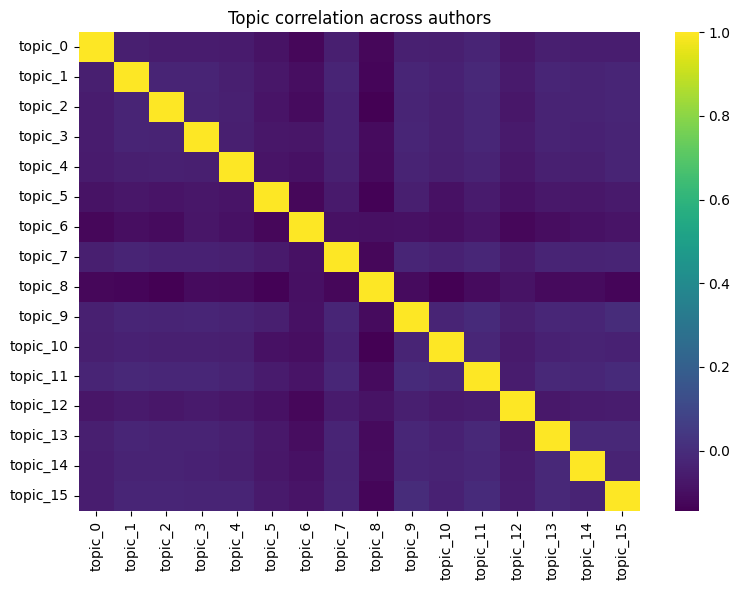


Number of authors: 1704
Fitting UMAP on topic vectors...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


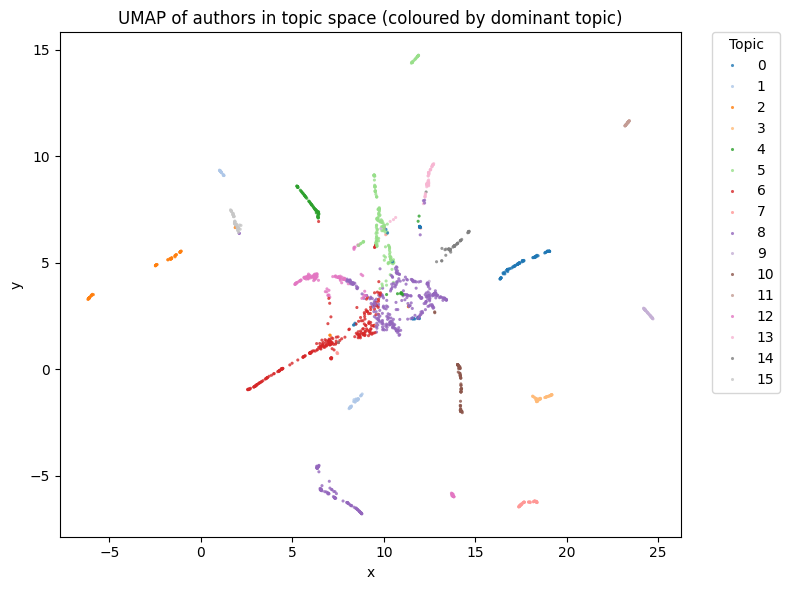

In [97]:


a_tag = str(ALPHA).replace(".", "p")
e_tag = str(ETA).replace(".", "p")

# Paths for this model
MODEL_DIR = BASE_DIR / REP
TOP_TERMS_PATH = MODEL_DIR / f"author_topics_{REP}_k{K}_a{a_tag}_e{e_tag}_top_terms.csv"
THETA_PATH     = MODEL_DIR / f"author_topic_matrix_{REP}_k{K}_a{a_tag}_e{e_tag}.csv"

print("Top terms file:", TOP_TERMS_PATH)
print("Theta matrix file:", THETA_PATH)

# ======================================================
# 2. LOAD DATA
# ======================================================

df_top = pd.read_csv(TOP_TERMS_PATH)
df_theta = pd.read_csv(THETA_PATH)

print("\nTop terms head:")
display(df_top.head())

print("\nTheta head:")
display(df_theta.head())

# Identify topic columns (everything except author_id)
topic_cols = [c for c in df_theta.columns if c != "author_id"]
num_topics = len(topic_cols)
print(f"\nDetected {num_topics} topic columns:", topic_cols)


# ======================================================
# 3. CLEAN HUMAN READABLE TOPIC DESCRIPTIONS
# ======================================================

def summarize_topics(df_top, df_theta, topic_cols, top_n=15, weight_round=2):
    """
    For each topic:
      - print top words with weights
      - show summary stats:
          mean topic weight across authors
          median topic weight
          share of authors with topic weight > threshold
    """
    # make sure topics are sorted
    topics = sorted(df_top["topic"].unique().tolist())

    # basic per topic statistics from theta
    theta_matrix = df_theta[topic_cols].values
    topic_means = theta_matrix.mean(axis=0)
    topic_medians = np.median(theta_matrix, axis=0)
    threshold = 0.1
    topic_active_frac = (theta_matrix > threshold).mean(axis=0)

    print("\n================ TOPIC SUMMARIES ================\n")

    for t in topics:
        # extract top terms for this topic
        sub = df_top[df_top["topic"] == t].sort_values("weight", ascending=False).head(top_n)
        terms = sub["term"].tolist()
        weights = sub["weight"].tolist()

        # basic stats
        idx = t  # assumes topics are numbered 0..K-1
        mean_w = topic_means[idx]
        med_w = topic_medians[idx]
        active_frac = topic_active_frac[idx]

        print(f"Topic {t}:")
        print(f"  Mean topic weight across authors: {mean_w:.3f}")
        print(f"  Median topic weight: {med_w:.3f}")
        print(f"  Share of authors with weight > {threshold}: {active_frac:.3f}")

        # build a compact description string
        word_bits = [f"{term} ({round(w, weight_round)})" for term, w in zip(terms, weights)]
        desc = ", ".join(word_bits)
        print(f"  Top terms: {desc}\n")


summarize_topics(df_top, df_theta, topic_cols, top_n=15, weight_round=2)


# ======================================================
# 4. TOPIC CORRELATION HEATMAP
# ======================================================

def plot_topic_correlation_heatmap(df_theta, topic_cols, figsize=(8, 6)):
    """
    Computes Pearson correlation between topic usage across authors
    and plots a heatmap.
    """
    topic_matrix = df_theta[topic_cols]
    corr = topic_matrix.corr()

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
    plt.title("Topic correlation across authors")
    plt.tight_layout()
    plt.show()


plot_topic_correlation_heatmap(df_theta, topic_cols)


# ======================================================
# 5. UMAP EMBEDDING OF AUTHORS IN TOPIC SPACE
# ======================================================

def plot_umap_authors(df_theta, topic_cols, n_neighbors=30, min_dist=0.1,
                      metric="euclidean", max_points=10000, random_state=42):
    """
    Reduces author topic vectors to 2D with UMAP and colours by dominant topic.
    For very large numbers of authors, optionally subsamples for plotting.
    """
    X = df_theta[topic_cols].values
    n_authors = X.shape[0]
    print(f"\nNumber of authors: {n_authors}")

    # Subsample if huge
    if n_authors > max_points:
        idx = np.random.RandomState(random_state).choice(n_authors, size=max_points, replace=False)
        X_sub = X[idx]
        author_ids_sub = df_theta["author_id"].iloc[idx].values
    else:
        X_sub = X
        author_ids_sub = df_theta["author_id"].values
        idx = np.arange(n_authors)

    # Compute dominant topic per author
    dominant_topic = X_sub.argmax(axis=1)

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric=metric,
        random_state=random_state
    )

    print("Fitting UMAP on topic vectors...")
    embedding = reducer.fit_transform(X_sub)

    # Build a DataFrame for plotting
    df_emb = pd.DataFrame({
        "author_id": author_ids_sub,
        "x": embedding[:, 0],
        "y": embedding[:, 1],
        "dominant_topic": dominant_topic
    })

    plt.figure(figsize=(8, 6))
    # Use a discrete palette for topics
    palette = sns.color_palette("tab20", num_topics)
    sns.scatterplot(
        data=df_emb,
        x="x",
        y="y",
        hue="dominant_topic",
        palette=palette,
        s=5,
        linewidth=0,
        alpha=0.8
    )
    plt.title("UMAP of authors in topic space (coloured by dominant topic)")
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    return df_emb


df_umap = plot_umap_authors(df_theta, topic_cols)


Topic 0: Bard launches

Topic 1: Musk commentary

Topic 2: Comedy media

Topic 3: Apps and tools

Topic 4: General reactions

Topic 5: Image generation

Topic 6: Big tech rivalry

Topic 7: Writing and style

Topic 8: Search engines

Topic 9: Humour and talk

Topic 10: Web development

Topic 11: Tech and jobs

Topic 12: LLM promotion

Topic 13: Copilot and blogs

Topic 14: Politics and woke

Topic 15: Content moderation


A. Topics 6 and 8 overlap more than any others

Both focus on tech rivalry, Google, Microsoft, Bing, OpenAI.
Topic 6 is general big tech competition.
Topic 8 is specifically search engines.

They share partial vocabularies (bard, google, bing) and are often used by the same authors.

These two form the strongest cluster.

B. Topics 5 and 12 form a soft pair

Topic 5 is generative images.
Topic 12 is LLM services and innovation.

Both are used by creative, early adopter, trend following users.
These authors often talk about both generative media and LLM announcements, so mild correlation is expected.

C. Topics 2, 9, and 15 form a discourse cluster

These are comedy, humour, Seinfeld, Twitch commentary.
They capture light hearted or culture commentary content.
Some content creators mix these topics.

D. Topics 3, 4, 7, 11, 13 form a weaker cloud

These are general usage, tools, reactions, web commentary, and jobs.
They do not overlap strongly but sit in the same broad region.
They represent generalist authors.

E. Topics 1 and 14 have mild overlap

These concern political talk, Musk, slurs, woke discourse.
They appear near each other, but remain distinct.

F. Some topics are nearly isolated

Topic 0 (Bard launches) sits near the top but is narrow and niche.
Topic 10 (web development) sits alone.
Topic 15 (content moderation and Twitch) is distinct.

Saving labelled plots to: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/plots_labeled


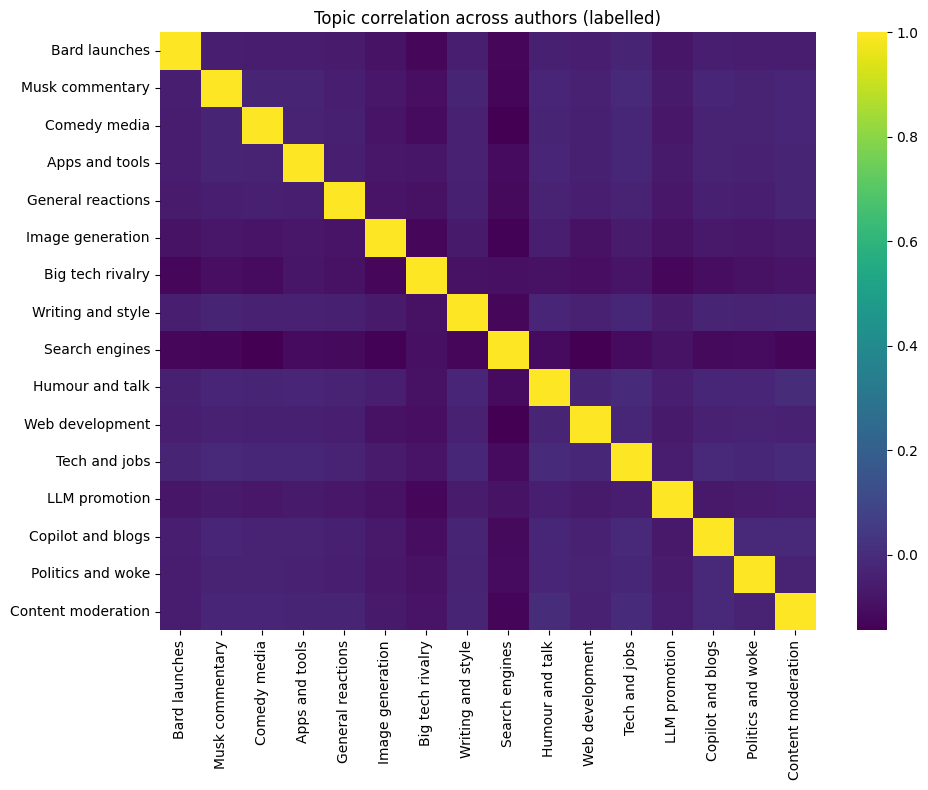

Saved: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/plots_labeled/topic_correlation_heatmap_labeled.png


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


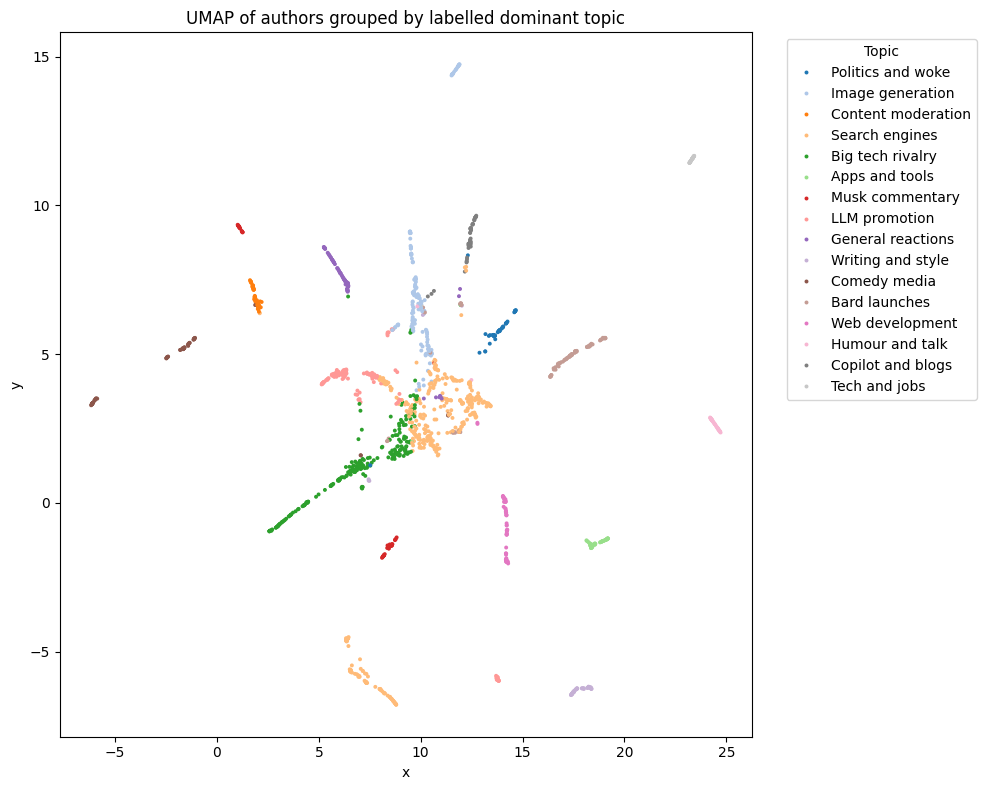

Saved: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/plots_labeled/umap_labeled_topics.png


In [12]:
# ======================================================
# CONFIG
# ======================================================

BASE_DIR = Path("/content/drive/MyDrive/AI Public Trust/Models/Topic Modeling/LDA/author_level")
REP = "tfidf_unigram"
K = 16
ALPHA = 0.1
ETA = 0.1

a_tag = str(ALPHA).replace(".", "p")
e_tag = str(ETA).replace(".", "p")

TOP_TERMS_PATH = BASE_DIR / REP / f"author_topics_{REP}_k{K}_a{a_tag}_e{e_tag}_top_terms.csv"
THETA_PATH     = BASE_DIR / REP / f"author_topic_matrix_{REP}_k{K}_a{a_tag}_e{e_tag}.csv"

# labels for topics
topic_labels = [
    "Bard launches",
    "Musk commentary",
    "Comedy media",
    "Apps and tools",
    "General reactions",
    "Image generation",
    "Big tech rivalry",
    "Writing and style",
    "Search engines",
    "Humour and talk",
    "Web development",
    "Tech and jobs",
    "LLM promotion",
    "Copilot and blogs",
    "Politics and woke",
    "Content moderation"
]

# Directory for labelled plots
PLOT_DIR = BASE_DIR / "plots_labeled"
PLOT_DIR.mkdir(parents=True, exist_ok=True)

print("Saving labelled plots to:", PLOT_DIR)

# ======================================================
# LOAD DATA
# ======================================================

df_top = pd.read_csv(TOP_TERMS_PATH)
df_theta = pd.read_csv(THETA_PATH)
topic_cols = [c for c in df_theta.columns if c.startswith("topic_")]

# ======================================================
# CORRELATION HEATMAP WITH LABELS
# ======================================================

corr = df_theta[topic_cols].corr()
corr.index = topic_labels
corr.columns = topic_labels

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="viridis")
plt.title("Topic correlation across authors (labelled)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

heatmap_path = PLOT_DIR / "topic_correlation_heatmap_labeled.png"
plt.savefig(heatmap_path, dpi=150)
plt.show()
print("Saved:", heatmap_path)

# ======================================================
# UMAP WITH LABELLED TOPICS
# ======================================================

X = df_theta[topic_cols].values
dominant_topic = X.argmax(axis=1)

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(X)

df_umap = pd.DataFrame({
    "x": embedding[:,0],
    "y": embedding[:,1],
    "topic": dominant_topic
})

plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab20", K)

sns.scatterplot(
    data=df_umap,
    x="x",
    y="y",
    hue=df_umap["topic"].map(lambda t: topic_labels[t]),
    palette=palette,
    s=8,
    linewidth=0
)

plt.title("UMAP of authors grouped by labelled dominant topic")
plt.legend(title="Topic", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()

umap_path = PLOT_DIR / "umap_labeled_topics.png"
plt.savefig(umap_path, dpi=150)
plt.show()
print("Saved:", umap_path)


# 8 Author Level and Sentiments

In [26]:
# ======================================================
# Refit canonical LDA model: tfidf_unigram, K=16, alpha=0.1, eta=0.1
# ======================================================

REP = "tfidf_unigram"
K = 16
ALPHA = 0.1
ETA = 0.1

# 1. Rebuild the TFIDF vectorizer with the same parameters as original
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words=stopwords_extended,
    max_df=0.95,
    min_df=5,
    ngram_range=(1,1),
    use_idf=True
)

# 2. Rebuild the corpus exactly as before
corpus = [author_docs[aid] for aid in author_ids]

# 3. Fit the vectorizer
X = vectorizer.fit_transform(corpus)

print("Vectorizer rebuilt. Shape:", X.shape)

# 4. Fit the LDA model
lda = LatentDirichletAllocation(
    n_components=K,
    doc_topic_prior=ALPHA,
    topic_word_prior=ETA,
    learning_method="batch",
    max_iter=20,
    random_state=42
)

lda.fit(X)
print("Canonical LDA model refitted.")


Vectorizer rebuilt. Shape: (1704, 1663)
Canonical LDA model refitted.


In [29]:
# ======================================================
# Save the model and vectorizer for future loading
# ======================================================

MODEL_DIR = BASE_DIR / REP
MODEL_DIR.mkdir(parents=True, exist_ok=True)

with open(MODEL_DIR / f"lda_model_k{K}_a0p1_e0p1.pkl", "wb") as f:
    pickle.dump(lda, f)

with open(MODEL_DIR / f"vectorizer_k{K}_a0p1_e0p1.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("Saved canonical model and vectorizer.")


Saved canonical model and vectorizer.


In [30]:
# The following paths already exist earlier in 3.4; no need to redefine BASE
CLEAN = BASE / "Data Sets" / "Cleaned Data"


In [31]:
# ======================================================
# Load canonical LDA model and vectorizer
# ======================================================
REP = "tfidf_unigram"
K = 16
ALPHA = 0.1
ETA = 0.1

MODEL_DIR = Path("/content/drive/MyDrive/AI Public Trust/Models/Topic Modeling/LDA/author_level") / "tfidf_unigram"

a_tag = str(ALPHA).replace(".", "p")
e_tag = str(ETA).replace(".", "p")

MODEL_DIR = BASE_DIR / "tfidf_unigram"
lda_path = MODEL_DIR / "lda_model_k16_a0p1_e0p1.pkl"
vec_path = MODEL_DIR / "vectorizer_k16_a0p1_e0p1.pkl"

with open(lda_path, "rb") as f:
    lda = pickle.load(f)
with open(vec_path, "rb") as f:
    vectorizer = pickle.load(f)


print("Loading LDA model:", lda_path)
print("Loading vectorizer:", vec_path)

with open(lda_path, "rb") as f:
    lda = pickle.load(f)

with open(vec_path, "rb") as f:
    vectorizer = pickle.load(f)


Loading LDA model: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/lda_model_k16_a0p1_e0p1.pkl
Loading vectorizer: /content/drive/My Drive/Colab Projects/AI Public Trust/Models/Topic Modeling/LDA/author_level/tfidf_unigram/vectorizer_k16_a0p1_e0p1.pkl


In [32]:
infile = CLEAN / "AItrust_pruned_twits_with_sentiment.json"
outfile = CLEAN / "AI_pruned_tweets_with_sentiment_topic_weights.json"

count_in = 0
count_out = 0

with open(infile, "r", encoding="utf8") as fin, \
     open(outfile, "w", encoding="utf8") as fout:

    for line in fin:
        count_in += 1
        t = json.loads(line)

        # optional filter: only keep tweets from LCC authors
        if t["author_id"] not in lcc_nodes:
            continue

        # infer topic weights
        X = vectorizer.transform([t["text"]])
        t["topic_weights"] = lda.transform(X)[0].tolist()

        # write out the updated tweet
        fout.write(json.dumps(t) + "\n")
        count_out += 1

        # clean up temporary object X
        del X

print("Lines read:", count_in)
print("Tweets written:", count_out)
print("Saved to:", outfile)


Lines read: 17410035
Tweets written: 65615
Saved to: /content/drive/My Drive/Colab Projects/AI Public Trust/Data Sets/Cleaned Data/AI_pruned_tweets_with_sentiment_topic_weights.json


In [37]:
!head -n 3 "/content/drive/MyDrive/AI Public Trust/Data Sets/Cleaned Data/AItrust_pruned_twits_with_sentiment.json"



{"id": "1622641267187253275", "text": "Hey \nyou need perfect scores and completely AI proof content in your assignments and essays🤩🤩?\nWe are your best made decision this semester we handle:\n✏MATLAB\n✏Mathematics\n✏Coding\n✏Accounting/Finance\n✏Web\n✏Python\n✏Tableau, Excel, SPSS Statistics", "created_at": "2023-02-06T16:59:59.000Z", "public_metrics": {"retweet_count": 0, "reply_count": 0, "like_count": 1, "quote_count": 0, "impression_count": 11}, "author_id": "1306286218150391810", "type": "original", "conversation_id": "1622641267187253275", "processed_text": "hey  you need perfect scores and completely ai proof content in your assignments and essays🤩🤩? we are your best made decision this semester we handle: ✏matlab ✏mathematics ✏coding ✏accounting/finance ✏web ✏python ✏tableau, excel, spss statistics", "sentiment_label": "positive", "sentiment_score": {"negative": 0.01034444011747837, "neutral": 0.14520736038684845, "positive": 0.8444481492042542}}
{"id": "1622641265455005712", "

In [38]:
author_sent_sum = defaultdict(lambda: defaultdict(float))
author_counts = defaultdict(int)
sentiment_dims = None

with open(outfile, "r", encoding="utf8") as fin:
    for line in fin:
        t = json.loads(line)

        # Skip tweets with no sentiment score
        if "sentiment_score" not in t:
            continue

        # Set sentiment dimension names once
        if sentiment_dims is None:
            sentiment_dims = list(t["sentiment_score"].keys())
            print("Detected sentiment dimensions:", sentiment_dims)

        aid = t["author_id"]

        # Add sentiment values
        for dim in sentiment_dims:
            author_sent_sum[aid][dim] += t["sentiment_score"][dim]

        author_counts[aid] += 1

# Convert sums to means
author_sentiment_mean = {
    aid: {
        dim: author_sent_sum[aid][dim] / author_counts[aid]
        for dim in sentiment_dims
    }
    for aid in author_sent_sum
}

with open(CLEAN / "author_sentiment_mean.pkl", "wb") as f:
    pickle.dump(author_sentiment_mean, f)

print("Saved author sentiment means.")



Detected sentiment dimensions: ['negative', 'neutral', 'positive']
Saved author sentiment means.


##. Summary
- Outputs are saved under `Models/Topic Modeling/LDA/author_level/`.
- Merge `author_topic_matrix_k{K}.csv` with LCC community labels for community profiles.
- Use `author_lda_model_report.csv` plus the top terms and pyLDAvis to pick a canonical K.